<div align="center"> <h1>Regression</h1>
    <h2><a href="...">Richard Leibrandt</a></h2>
</div>

In [1]:
import pandas as pd
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

np.set_printoptions(linewidth=800)
np.set_printoptions(edgeitems=20)
pd.set_option('display.width', 700)
pd.options.display.max_colwidth = 100
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [2]:
import altair as alt
alt.data_transformers.disable_max_rows()
alt.renderers.enable('altair_viewer')
alt.renderers.enable('mimetype')

RendererRegistry.enable('mimetype')

In [3]:
# We load the data "boston"
from sklearn.datasets import load_boston
boston = load_boston()
X = boston.data
y = boston.target

# We build the data into a DataFrame
data = pd.DataFrame(boston.data)
data.columns = boston.feature_names
data['PRICE'] = boston.target

# Regression

In [4]:
# We perform a train-test-split

mytuple = train_test_split(X, y, test_size=0.2, random_state=123)
X_train = mytuple[0]
X_test = mytuple[1]
y_train = mytuple[2]
y_test = mytuple[3]
# is the same as:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [5]:
# We configure the (unfitted) model (in other words, we configure the algorithm that produces the fitted model - depending on the view):
regr = LinearRegression()

# We fit the model - sometimes one says "we train the model":
regr.fit(X_train, y_train)

# Finally, we evaluate on both - the training data and the test data, which was known during training.
# Take note that the evaluation is generally better for the training data than for the test data, but that the evaluation on the test data is the critical one.
print(regr.score(X_train, y_train))
print(regr.score(X_test, y_test))
# here we use the R^2 score.

0.7559380876016175
0.6592466510354105


In [6]:
# Exkurs: Coefficient of determination (Bestimmtheitsmaß oder Determinationskoeffizient) R^2
# https://en.wikipedia.org/wiki/Coefficient_of_determination
# https://de.wikipedia.org/wiki/Bestimmtheitsma%C3%9F
# R = 1 - ( Sum_of_squares_Residuen / Sum_of_squares_Variable ) = 1 - ( ( Sum_of_squares_Residuen / nr_samples ) / Variance_Variable )
# One can interpret this as a comparison of our model with a linear model, which has only one intercept and no coefficients. 
residuen = np.abs(y_test - regr.predict(X_test))
Sum_of_squares_Residuen = np.sum(residuen ** 2)
Sum_of_squares_Variable = np.sum((y_test - np.mean(y_test)) ** 2)
print(1 - Sum_of_squares_Residuen / Sum_of_squares_Variable)

0.6592466510354105


In [7]:
# That's all very nice, but we build models to get the output for new, completely unseen input data. 
# Of course, completely new data is not available.
y_train_predicted = regr.predict(X_train)
y_test_predicted = regr.predict(X_test)

# Now we use the predicted results to calculate the mean square deviation:
# https://en.wikipedia.org/wiki/Mean_squared_error
# https://de.wikipedia.org/wiki/Mittlere_quadratische_Abweichung
print(np.sum((y_train_predicted - y_train) ** 2) / y_train_predicted.shape[0])
print(np.sum((y_test_predicted - y_test) ** 2) / y_test_predicted.shape[0])

20.677107947815138
28.192485758469484


In [8]:
#  We can also display coefficients and the intercept:
print(regr.coef_)
print(regr.intercept_)

[-9.87931696e-02  4.75027102e-02  6.69491841e-02  1.26954150e+00 -1.54697747e+01  4.31968412e+00 -9.80167937e-04 -1.36597953e+00  2.84521838e-01 -1.27533606e-02 -9.13487599e-01  7.22553507e-03 -5.43790245e-01]
31.835164121206397


In [9]:
# Now let's do the whole thing with another model:

regr_gp = GaussianProcessRegressor(alpha=1e-10).fit(X_train, y_train)
regr_gp.predict(X_test)
print(regr.score(X_train, y_train))
print(regr.score(X_test, y_test))

0.7559380876016175
0.6592466510354105


In [10]:
# We bring the results into the data frame:
data['PRICE_lin'] = regr.predict(X)
data['PRICE_gp'] = regr_gp.predict(X)
data['row_nr'] = data.index
data_plot = data.melt(id_vars=['row_nr', 'PRICE'],
                      value_vars=['PRICE_lin', 'PRICE_gp']).sort_values('row_nr')

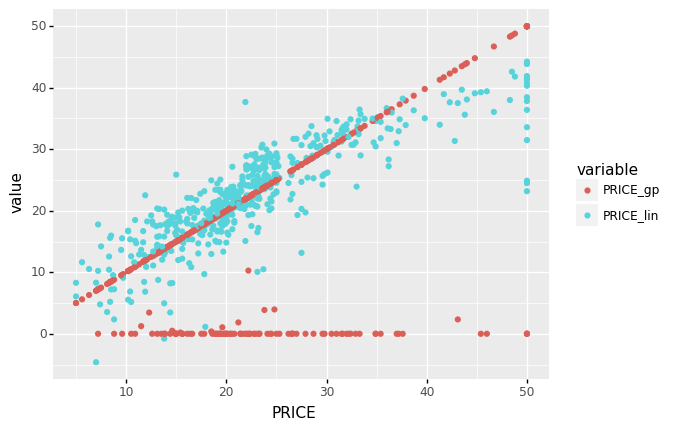

<ggplot: (8787597992262)>

In [11]:
# VISUALISATION
# Now, we plot this:
import plotnine as pn
pn.ggplot(data_plot, pn.aes(x='PRICE', y='value', color='variable')) + pn.geom_point()

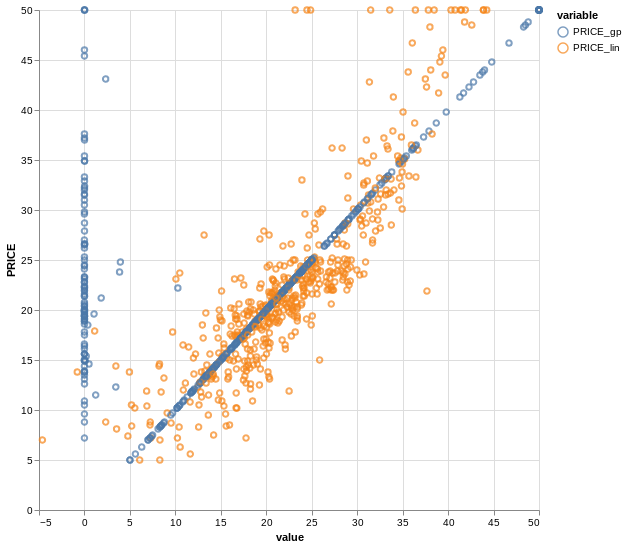

In [12]:
# VISUALISATION
# install with: pip install altair altair_viewer
(alt.Chart(data_plot).
 properties(height=500, width=500).
 mark_point().
 encode(x='value',
        y='PRICE',
        color='variable')
)

# Linear Regression - with categorical input data

Let's apply a linear regression model to the data.

Fist we need to split the data in two groups. A training group and a test group.

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression

In [14]:
car_prices=pd.read_csv("../data/car_prices.csv")

features = (car_prices[['length', 'width', 'height', 'engine-size',  'stroke', 'compression-ratio', 'horsepower', 'price']]
            .replace('?', '', regex=False)
            .apply(pd.to_numeric, errors='coerce'))

features_std = StandardScaler().fit_transform(features)
features_imp = SimpleImputer(strategy='mean').fit_transform(features_std)

X_train, X_test, y_train, y_test = train_test_split(features_imp[:,:-1],
                                                    features_imp[:,-1],
                                                    test_size=0.30, random_state=1)

Train the model:

In [15]:
regr = LinearRegression()
regr.fit(X_train, y_train)

LinearRegression()

Let's see how good we did using the test group. The method ```score``` calculates the R² value.

In [16]:
regr.score(X_test, y_test)  # 

0.7811270144233217

Let's visualize the predictions against the real values:

In [17]:
predictions= regr.predict(X_test)

In [18]:
# Scale back the data to the original representation using the values used in the transformation
predictions_rev=predictions*7.94704014e+03+1.32056900e+04
y_test_rev= y_test*7.94704014e+03+1.32056900e+04

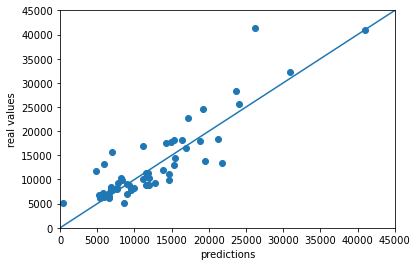

In [19]:
# VISUALISATION
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

plt.scatter(predictions_rev, y_test_rev)
plt.xlabel('predictions')
plt.ylabel('real values')
plt.xlim([0,45000])
plt.ylim([0,45000])
plt.plot([0,45000],[0,45000])

## Encoding categorical features

Let's try to add three of the categorical features. Here we include the price so that we are able to exclude observations where 'price' is missing:

In [20]:
cat_features=car_prices[['fuel-type', 'num-of-doors', 'body-style', 'price']]
cat_features=cat_features.dropna(axis=0, subset=['price'])
cat_features=cat_features.drop('price', axis=1)

In [21]:
cat_features.head()

,fuel-type,num-of-doors,body-style
0,gas,two,convertible
1,gas,two,convertible
2,gas,two,hatchback
3,gas,four,sedan
4,gas,four,sedan


One simple way to represent categories is to attribute one number to each category. This can however introduce relations between categories that don't exist in reality. Imagine that we map the 'body-style' feature to integers with: 'convertible'=1, 'hatchback'=2 and 'sedan'=3. Now the 'sedan' is bigger than 'hatchback' that is in turn bigger than 'convertible'.

One solution is "One-hot-encoding", which basically is creating new features that represent each category, having a one where that category exists and zero otherwise. There is a *scikit-learn* function to do it but *pandas* has a simpler method:

In [22]:
ohe_features=pd.get_dummies(cat_features)
ohe_features.head(5)

,fuel-type_diesel,fuel-type_gas,num-of-doors_?,num-of-doors_four,num-of-doors_two,body-style_convertible,body-style_hardtop,body-style_hatchback,body-style_sedan,body-style_wagon
0,0,1,0,0,1,1,0,0,0,0
1,0,1,0,0,1,1,0,0,0,0
2,0,1,0,0,1,0,0,1,0,0
3,0,1,0,1,0,0,0,0,1,0
4,0,1,0,1,0,0,0,0,1,0


Let's append these features to the scaled Dataframe:

In [23]:
features_df=pd.DataFrame(features_imp,
                         columns=['length', 'width', 'height', 'engine-size', 'stroke', 'compression-ratio', 'horsepower', 'price'])
print(features_df.head())

ohe_features = ohe_features.reset_index()  # we need to reset the index
features_all = pd.concat([features_df, ohe_features], axis=1)

     length     width    height  engine-size    stroke  compression-ratio  horsepower     price
0 -0.426521 -0.844782 -2.020417     0.074449 -1.821370          -0.288349    0.170228  0.036314
1 -0.426521 -0.844782 -2.020417     0.074449 -1.821370          -0.288349    0.170228  0.415385
2 -0.231513 -0.190566 -0.543527     0.604046  0.679195          -0.288349    1.255637  0.415385
3  0.207256  0.136542  0.235942    -0.431076  0.457626          -0.035973   -0.056950  0.093711
4  0.207256  0.230001  0.235942     0.218885  0.457626          -0.540725    0.271197  0.535224


... and create a linear regression model again:

In [24]:
features_wo_target=features_all.drop('price', axis=1)
X_train, X_test, y_train, y_test = train_test_split(features_wo_target, features_all['price'],
    test_size=0.30, random_state=1)

In [25]:
regr=LinearRegression()

regr.fit(X_train, y_train)

LinearRegression()

In [26]:
regr.score(X_test, y_test) 

0.7870902255861031

The inclusion of these three categorical features reduced the prediction error.